# Кластеризация пользователей мобильного приложения

**Цель проекта**.

На основе поведения в мобильном приложении "Ненужные вещи" `выделить группы пользователей`, которые различаются по метрикам:

- retention rate; 


- время, проведённое в приложении;


- частота действий;


- конверсия в целевое действие - просмотр контактов.

**Задачи**:

- Провести исследовательский анализ данных;


- Создать профили пользователей и выбрать признаки для кластеризации;


- Определить оптимальное количество кластеров и провести кластеризацию пользователей;


- Проанализировать поведение групп пользователей с учетом их кластера;


- Проверить статистические гипотезы;


- Составить рекомендации по работе с группами пользователей на основании полученных выводов.

## Дополнительные материалы

* **Презентация** для маркетингового отдела с итогами кластеризации пользователей

(https://drive.google.com/file/d/10sys1lI8yltdvGYX7FKc0VCE6ci5kaXr/view?usp=sharing)


* **Дашборд** статистики событий в приложении, включающий в себя графики:

    - распределения событий по дням и их типу;
    - количества пользователей, согласно источнику привлечения.

(https://public.tableau.com/app/profile/albina4684/viz/Book1_16474434589790/Dashboard1)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import scipy.stats as st

In [2]:
#добавим стилизацию для графиков

sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set(palette = 'muted')

In [3]:
dataset = pd.read_csv('/datasets/mobile_dataset.csv')
sources = pd.read_csv('/datasets/mobile_soures.csv')

display(
    dataset.head(),
    sources.head()
)

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


Описание данных таблицы `dataset`:

- `event.time` — время совершения события;


- `event.name` — название события;


- `user.id` — идентификатор пользователя.


Описание данных таблицы `sources`:

- `userId` — идентификатор пользователя;


- `source` — источник, с которого пользователь установил приложение.



In [4]:
#посмотрим, какие события есть в датасете

dataset['event.name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7', 'show_contacts'], dtype=object)

Расшифровки событий:

- `advert_open` — открытие карточки объявления;


- `photos_show` — просмотр фотографий в объявлении;


- `tips_show` — пользователь увидел рекомендованные объявления;


- `tips_click` — пользователь кликнул по рекомендованному объявлению;


- `contacts_show` и `show_contacts` — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления;


- `contacts_call` — пользователь позвонил по номеру телефона на карточке объявления;


- `map` — пользователь открыл карту размещенных объявлений;


- `search_1` — `search_7` — разные события, связанные с поиском по сайту;


- `favorites_add` — добавление объявления в избранное.

## Предобработка данных

Проведем исследование:

- корректности наименований колонок (изменим названия для удобства).


- соответствия типов данных столбцов (при необходимости, переведем в подходящие для анализа типы данных);


- пропущенных значений (если возможно, заполним их);


- наличия дубликатов (при нахождении - удалим);

Следует отметить, что названия событий `contacts_show` и `show_contacts` представляют собой одно и тоже - выберем из них тот, что указан в большинстве случаев.

In [5]:
#переименуем названия колонок в таблицах

dataset.columns = ['event_time', 'event_name', 'user_id']

sources.columns = ['user_id', 'source']

#проверим типы данных колонок

display(dataset.info())
sources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event_time  74197 non-null  object
 1   event_name  74197 non-null  object
 2   user_id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  4293 non-null   object
 1   source   4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


`Пропусков в данных нет`, но столбец `event_time` в dataset не соответствует своему типу - переведем его `в тип данных datetime`.

In [6]:
dataset['event_time'] = pd.to_datetime(dataset['event_time'], format = '%Y.%m.%d %H:%M:%S')

display(
    dataset.info(),
    dataset.head()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


None

,event_time,event_name,user_id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [7]:
#проверим таблицы на наличие дубликатов

display(
    dataset.duplicated().sum(),
    sources.duplicated().sum()
)

0

0

`Дубликатов в таблицах не обнаружено`.

Проверим, как часто встречаются события `contacts_show` и `show_contacts`. 
Тот, что лидирует по количеству использования, будет шаблоном для переименования второго.

In [8]:
dataset['event_name'].value_counts()

tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4450
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
show_contacts       79
Name: event_name, dtype: int64

In [9]:
#переименуем событие show_contacts в contacts_show

dataset['event_name'] = dataset['event_name'].replace('show_contacts', 'contacts_show')

### Вывод

В ходе предобработки данных `не были обнаружены пропуски и дубликаты`.

`Колонки таблиц были переименованы` для удобства работы.

В таблице dataset:

- event.time в event_time;

- event.name - event_name; 

- user.id - user_id.

В таблице sources:

- userId в user_id.

Колонке `event_time` в таблице dataset был присвоен `тип данных datetime`, что соответствует ее содержанию.

Названия событий `contacts_show` и `show_contacts` отражали одно и тоже действие, но show_contacts встречался гораздо реже, поэтому он был `переименован` в contacts_show.



## Исследовательский анализ данных

### DAU и WAU.

Выясним, сколько людей пользуются приложением в день и неделю: 

- рассчитаем DAU и WAU;

- отобразим изменения метрик во времени на графиках;

- вычислим средние значения этих метрик за весь период. 


In [10]:
# определим минимальную и максимальную даты привлечения пользователей.

display(
    dataset['event_time'].min(),
    dataset['event_time'].max()
)

Timestamp('2019-10-07 00:00:00.431357')

Timestamp('2019-11-03 23:58:12.532487')

Мы располагаем событиями, которые совершались в период `с 7 октября по 3 ноября 2019` года включительно.

In [11]:
#добавим столбцы с датой и неделей в dataset

dataset['dt'] = dataset['event_time'].dt.date
dataset['week'] = dataset['event_time'].dt.week

#расчитаем dau и wau

dau = (
    dataset.groupby('dt')
    .agg({'user_id' : 'nunique'})
)   

wau = (
    dataset.groupby('week')
    .agg({'user_id' : 'nunique'})
)

display(dau.head(), wau.head())

/tmp/ipykernel_117/1379168675.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  dataset['week'] = dataset['event_time'].dt.week


,user_id
dt,
2019-10-07,204
2019-10-08,204
2019-10-09,227
2019-10-10,233
2019-10-11,206


,user_id
week,
41,1130
42,1438
43,1546
44,1416


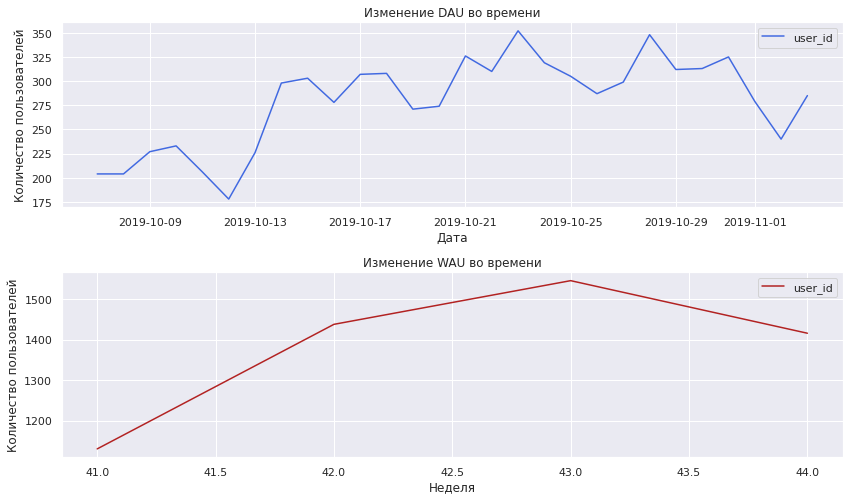

In [12]:
#отобразим на графиках изменение метрик во времени 

fig, axs = plt.subplots(2, 1, figsize = (14,8)) 
plt.subplots_adjust(hspace= 0.35)

dau.plot(ax = axs[0], grid=True, color = 'royalblue')
axs[0].set_title('Изменение DAU во времени')
axs[0].set_xlabel('Дата')
axs[0].set_ylabel('Количество пользователей')

wau.plot(ax = axs[1], grid=True, color = 'firebrick')
axs[1].set_title('Изменение WAU во времени')
axs[1].set_xlabel('Неделя')
axs[1].set_ylabel('Количество пользователей')

plt.show()

Можно заметить, что `рост количества событий` наблюдается с 14.10.2019г., что соответствует второй по счету недели в датасете.

В течение 3-х недель (41-43) количество событий росло, к 44 неделе наблюдалось падение.

In [13]:
#вычислим средние значения DAU и WAU

dau_wau_mean = pd.concat([round(dau.mean()), round(wau.mean())]).T
dau_wau_mean.index = ['dau', 'wau']

dau_wau_mean

dau     279.0
wau    1382.0
dtype: float64

**Вывод**

В `среднем` приложением пользуются `279 человек в день`, `в неделю` средний показатель составляет `1 382 человека`.

На протяжении первой недели `активность была минимальна` и составляла до 230 человек в день. 

После чего (с 14 октября 2019 года) средняя посещаемость `начала заметно расти` и достигла своего пика на 43 неделе, когда средняя посещаемость составляла 275-350 человек в день и более 1 500 в течение всей недели.

На `последней неделе` наблюдался `небольшой спад посещаемости` чуть больше 1 400 человек в неделю.

### События

Рассмотрим, как распределяются события во времени и между пользователями.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


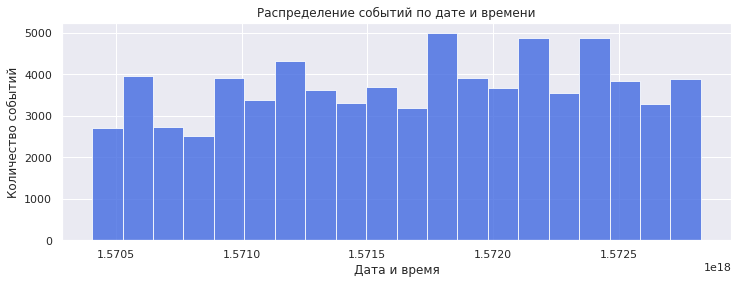

In [14]:
#построим гистограмму распределения событий

plt.figure(figsize = (12,4))

sns.distplot(
    dataset['event_time'], bins = 20, kde=False,
    hist_kws = {'alpha':.8}, color = 'royalblue')

plt.title('Распределение событий по дате и времени')
plt.xlabel('Дата и время')
plt.ylabel('Количество событий')
plt.show()

В день пользователями совершается `2 500 - 3 600 событий`.

Можно заметить, что количество событий росло в течение недели.

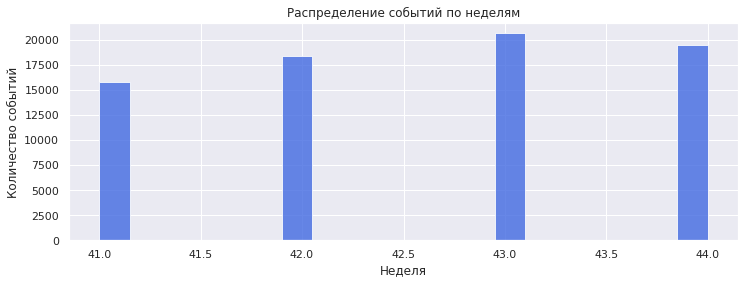

In [15]:
#рассмотрим недельные показатели

plt.figure(figsize = (12,4))

sns.distplot(
    dataset['week'], bins = 20, kde=False,
    hist_kws = {'alpha':.8}, color = 'royalblue')

plt.title('Распределение событий по неделям')
plt.xlabel('Неделя')
plt.ylabel('Количество событий')
plt.show()

Рост количества событий с течением недели подтвердился.

- в течение `41 недели` было совершено `более 15 000` событий;


- в течение `42` - `более 17 500` событий;


- `43 неделя` - `более 20 000` событий;


- за `44 неделю` показатели немного упали - `чуть меньше 20 000`.

In [16]:
#посмотрим средние показатели в день и неделю

display(
    dataset.groupby('dt')['event_name'].count().mean(),
    dataset.groupby('week')['event_name'].count().mean()
)

2649.8928571428573

18549.25

**Вывод**

В среднем пользователями совершается `2 650` событий в день и `18 549` в неделю.

Количество событий росло с течением времени - каждую неделю показатель становился выше и достиг своего максимума на `43 неделе` (21-27 октября 2019г.). Количество событий на этой неделе составило `более 20 000`.

После 43 недели (c 28.10.2019) наблюдалось небольшое падение.

Посмотрим **распределение событий между пользователями**.

In [17]:
#построим таблицу с количеством событий и сколько пользователей их совершили хотя бы один раз

users_count = (
    dataset.groupby('event_name')
    .agg({'event_time' : 'count',      # всего событий
          'user_id' : 'nunique'})      # уникальные пользователи
    .rename(columns = {
                        'event_time' : 'count', 
                        'user_id' : 'users'
                      })
    .reset_index()
)

users_count['count_for_user'] = round(users_count['count'] / users_count['users']) #кол-во каждого события на пользователя

users_count.sort_values(by = 'count_for_user', ascending = False)

,event_name,count,users,count_for_user
14,tips_show,40055,2801,14.0
5,photos_show,10012,1095,9.0
0,advert_open,6164,751,8.0
2,contacts_show,4529,981,5.0
3,favorites_add,1417,351,4.0
6,search_1,3506,787,4.0
1,contacts_call,541,213,3.0
4,map,3881,1456,3.0
8,search_3,522,208,3.0
13,tips_click,814,322,3.0


In [18]:
#посмотрим, сколько действий в среднем приходится на одного пользователя

round(
    len(dataset['event_name']) / len(dataset['user_id'].unique())
)

17

In [19]:
#расчитаем какую долю составляет целевое событие ("просмотр контактов") от общего числа событий

round(
    len(dataset['event_name']) / (len(dataset[dataset['event_name'] == 'contacts_show'])), 2
)

16.38

**Вывод**

Среднее количество `событий на пользователя` - `17` действий.

Cамое часто из них `tips_show` (увидел рекомендованные объявления) - в среднем `14 событий` на пользователя. Это событие самое частое потому, что показывается всем пользователям автоматически.

Другие частые события по количеству среди пользователей:

- `photos_show` (просмотр фотографий в объявлении) - `9 событий` на пользователя;


- `advert_open` (открытие карточки объявления) - в среднем `8 событий`;


- `contacts_show`	(посмотрел контакты) - `5 событий`.

Последнее действие (contacts_show) является целевым. Была расчитана доля переходов к этому событию - 16.38.

Это говорит о тому, что `16.38%` от общего числа событий составляет `"просмотр контактов"`.


### Источники

Проверим, ***есть ли принципиальная разница*** в поведении пользователей в зависимости от источника привлечения.

- оценим `распределение событий` во времени (различаются ли гистограммы по своему характеру?);


- расчитаем, сколько в среднем `событий` приходится `на пользователя`;


- посмотрим, какое количество `каждого события` приходится на одного пользователя.

In [20]:
#объединим таблицы dataset и sources

dataset = dataset.merge(sources, on = 'user_id', how = 'left')

#посмотрим, сколько пользователей пришли по каждому источнику

dataset.groupby('source')['user_id'].nunique().sort_values(ascending = False)

source
yandex    1934
other     1230
google    1129
Name: user_id, dtype: int64

Большая часть пользователей установила мобильное приложение по ссылке из `Yandex` - `1 934` человека.

Меньше всего пользователей пришло из `Google` - `1 129` человек.

`Другой источник` для установки использовало `1 230` пользователей.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


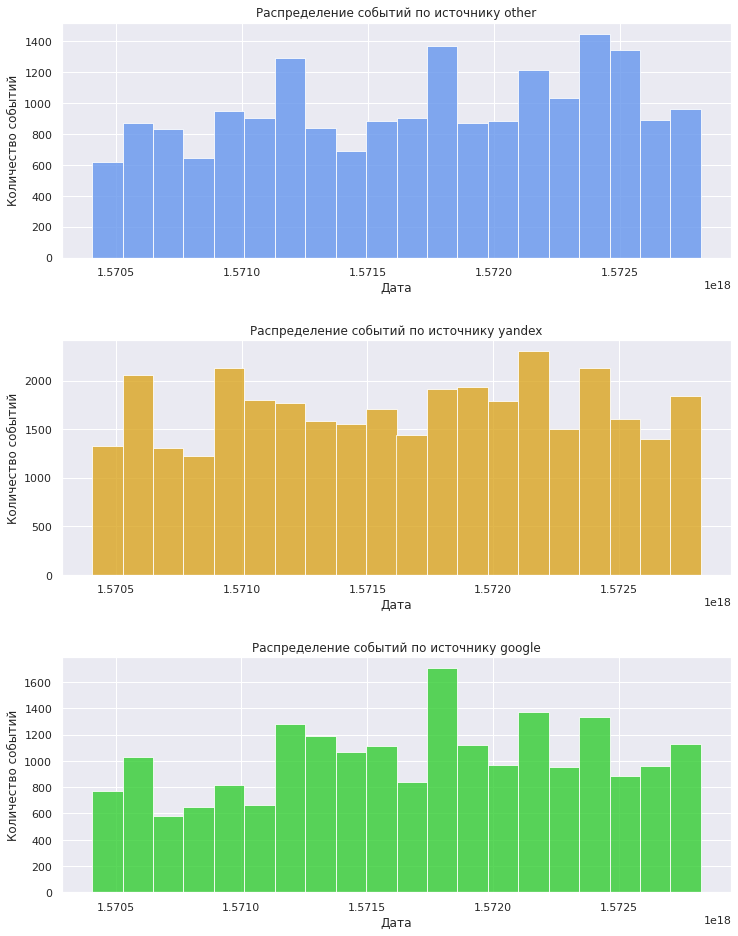

In [21]:
#оценим распределение событий во времени по каждому источнику

fig, axs = plt.subplots(3,1, figsize = (12, 16))
plt.subplots_adjust(hspace= 0.35)

colors = ['cornflowerblue', 'goldenrod', 'limegreen'] #применим разные цвета для гистограмм
col = 0
a = 0

for name in dataset['source'].unique():
    
    sns.distplot(
        dataset[dataset['source'] == name]['event_time'],
        ax = axs[a], 
        bins = 20, 
        kde=False, 
        hist_kws = {'alpha':.8}, 
        color = colors[col]
    )

    axs[a].set_title('Распределение событий по источнику {}'.format(name))
    axs[a].set_xlabel('Дата')
    axs[a].set_ylabel('Количество событий')
    
    a += 1
    col += 1
    
plt.show()

Характер распределения `похожий` у пользователей, установивших приложение из `google и other` (других источников).

События у пользователей из `yandex` распределяются `стабильнее`, но значительной разницы не наблюдается.

In [22]:
#расчитаем среднее количество событий на пользователя

round(
    dataset.groupby('source')['event_name'].count() / dataset.groupby('source')['user_id'].nunique()
)

source
google    18.0
other     16.0
yandex    18.0
dtype: float64

In [23]:
#посмотрим среднее количество каждого действия на пользователя
(
    round(
    dataset.groupby(['source','event_name'])['user_id'].count() /
    dataset.groupby(['source','event_name'])['user_id'].nunique()
    )
    .reset_index()
    .pivot_table(index = 'event_name',
                columns = 'source',
                values = 'user_id')
    .sort_values(by = ['yandex', 'google', 'other'], ascending  = False)
)    

source,google,other,yandex
event_name,,,
tips_show,15.0,12.0,15.0
advert_open,8.0,7.0,9.0
photos_show,10.0,10.0,8.0
search_1,5.0,4.0,5.0
favorites_add,4.0,3.0,5.0
contacts_show,5.0,5.0,4.0
map,3.0,2.0,3.0
search_3,3.0,2.0,3.0
tips_click,3.0,2.0,3.0


`В среднем `на каждого пользователя, установившего приложение из `google и yandex`, приходится `18` событий.

На пользователей из других источников (`other`) - `16` событий.

Самые `частые события`, согласно среднему распределению на пользователя:

- `tips_show`	- увидел рекомендованные объявления (google и yandex - 15, other - 12)


- `photos_show` - просмотр фотографий (google и yandex - 10, other - 8);


- `advert_open` - открытие карточки объявления (google - 8, yandex - 9, other - 7);


- `search_1` - поиск по приложению (google и yandex - 5, other - 4).


Количество целевых событий (`contacts_call`) - минимально. 

В среднем их приходится на каждого пользователя из источников `google и yandex` - `по 2` события. Для пользователей из других источников (`other`) их немного больше - `3` события.


Средние показатели у источников `google` и `yandex` часто повторяются, хотя количество людей в этих грппах разное - `1 129` и `1 934` соответственно.

Среднее распределение событий по пользователям источника `other` (1 230 человек) `немного ниже`, чем у первых двух.

Сказать, что пользователи в среднем по разному совершают события в зависимости от источника установки, мы не можем.

Полученные средние `показатели не выявили координальных различий`.

### Вывод

В ходе исследовательского анализа данных были проанализированы средние показатели по датафрейму.

**DAU и WAU**. 

В `среднем` приложением пользуются `279 человек в день`, `в неделю` средний показатель составляет `1 382 человека`. На протяжении первой недели `активность была минимальна` и составляла до 230 человек в день. 

После чего (с 14 октября 2019 года) средняя посещаемость `начала заметно расти` и достигла своего пика на 43 неделе, когда средняя посещаемость составляла 275-350 человек в день и более 1 500 в течение всей недели.

На `последней неделе` наблюдался `небольшой спад посещаемости` чуть больше 1 400 человек в неделю.

**Событийная статистика**. 

В среднем пользователями совершается `2 650` событий в день и `18 549` в неделю.

Количество событий росло с течением времени - каждую неделю показатель становился выше и достиг своего максимума на `43 неделе` (21-27 октября 2019г.). Количество событий на этой неделе составило `более 20 000`.

После 43 недели (c 28.10.2019) наблюдалось небольшое падение.


Среднее количество `событий на пользователя` - `17` действий.

Cамое часто из них `tips_show` (увидел рекомендованные объявления) - в среднем `14 событий` на пользователя. Это событие самое частое потому, что показывается всем пользователям автоматически.

Другие частые события по количеству среди пользователей:

- `photos_show` (просмотр фотографий в объявлении) - `9 событий` на пользователя;


- `advert_open` (открытие карточки объявления) - в среднем `8 событий`;


- `contacts_show`	(посмотрел контакты) - `5 событий`.

Последнее действие (contacts_show) является целевым. Была расчитана доля переходов к этому событию - 16.38.

Это говорит о тому, что `16.38%` от общего числа событий составляет `"просмотр контактов"`.

Исследование событий по **источнику установки приложения** не выявили координальных различий между пользователями.

`В среднем `на каждого пользователя, установившего приложение из `google и yandex`, приходится `18` событий.

На пользователей из других источников (`other`) - `16` событий.

Средние показатели у источников `google` и `yandex` часто повторяются, хотя количество людей в этих грппах разное - `1 129` и `1 934` соответственно.

Среднее распределение событий по пользователям источника `other` (1 230 человек) `немного ниже`, чем у первых двух.

Самые `частые события`, согласно среднему распределению на пользователя:

- `tips_show`	- увидел рекомендованные объявления (google и yandex - 15, other - 12)


- `photos_show` - просмотр фотографий (google и yandex - 10, other - 8);


- `advert_open` - открытие карточки объявления (google - 8, yandex - 9, other - 7);


- `search_1` - поиск по приложению (google и yandex - 5, other - 4).


## Пользовательские профили

### Создание сессий

Введем id-сесиий. Это позволит нам в дальнейшем посчитать время, которое каждый пользователь провел в приложении.

Сделаем это в несколько этапов:

- `расчитаем таймлаг` между соседними действиями у каждого пользователя. 

Это позволит нам определить, сколько времени могло длиться каждое событие до перехода к следующему. Также благодаря этому показателю, мы поймем, какое время можно считать порогом для завершения сессии.

- `присвоим каждому событию номер уникальной сессии`, в которой оно произошло.

In [24]:
#расчитаем разницу во времени между текущим и последующим событием у каждого пользователя

for name in dataset['user_id'].unique():
    user = dataset[dataset['user_id'] == name].sort_values(by = 'event_time')
    a = 1
    for row in user.index:                   #текущий индекс
        for next_row in user.index[a: a+1]:  #следующий индекс
            
            delta = user.loc[next_row, 'event_time'] - user.loc[row, 'event_time']
            dataset.loc[next_row, 'time_lag'] = round(delta.total_seconds(), 2)
            a += 1

            
dataset.head()

,event_time,event_name,user_id,dt,week,source,time_lag
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,41,other,NaN
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,41,other,0.80
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07,41,yandex,NaN
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,41,other,5.80
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07,41,yandex,54.07


Возьмем `для примера первого пользователя`и посмотрим распределение таймлагов.

In [25]:
dataset[dataset['user_id'] == '020292ab-89bc-4156-9acf-68bc2783f894'].sort_values(by = 'event_time').head(5)

,event_time,event_name,user_id,dt,week,source,time_lag
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,41,other,NaN
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,41,other,0.80
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,41,other,5.80
6,2019-10-07 00:01:27.770232,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,41,other,80.73
7,2019-10-07 00:01:34.804591,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,41,other,7.03


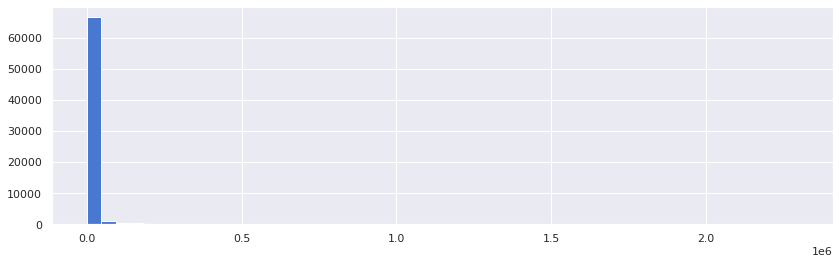

In [26]:
#визуализируем распределение таймлагов

plt.figure(figsize = (14, 4))

dataset['time_lag'].hist(bins = 50)
plt.show()       

Гистограмма не наглядная. `Сделаем срез по оси абцисс`. 

Предположем, что разница между действиями до 200 секунд (около 3 минут) - вполне нормальная: пользователь мог долго просматривать фотографии объявления. 

Ограничим график до 1000 секунд (около 16 минут).

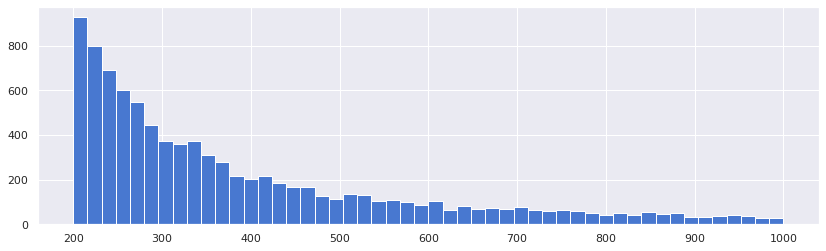

In [27]:
plt.figure(figsize = (14, 4))

dataset['time_lag'].hist(bins = 50, range = (200, 1000))
plt.show() 

Когда люди активно проводят время в приложение, длительность между событиями у них +- похожа. По графику мы видим, что обычная длительность между событиями - до 350 секунд.

После этого значения длительность между событиями становится все более различной у пользователей. Скажем, пользователь мог просматривать фотографии, думать и решать, параллельно искать информацию о товаре с компьютера. Мало вероятно, что все эти действия пользователь мог совершать более чем 10 минут и не сделать ни одного действия в приложении.

Определим наш `порог` для завершения сессии в `600 секунд` (10 минут), как психологически удобную границу. После этого значения уже наблюдается малое количество событий, поэтому эти случаи скорее похожи на другие сессии. 

Теперь мы можем **присвоить** каждому событию **номер сессии**. 

Сделаем это в цикле: у каждого пользователя сравним значение таймлага с пороговым (600 секунд). Если оно превышает данное значение, то будем считать, что сессия завершилась, и для последующего события номер сессии увеличим на единицу. Когда перейдем к следующему пользователю, также увеличим номер сессии на единицу.

In [28]:
#заполним пропуски у таймлагов первых событий у каждого пользователя

dataset['time_lag'] = dataset['time_lag'].fillna(0)

In [29]:
#создадим столбец с id-сессий

n = 1 

for name in dataset['user_id'].unique():
    user = dataset[dataset['user_id'] == name].sort_values(by = 'event_time')
    
    for row in user.index:
        if user.loc[row, 'time_lag'] <= 600:
            dataset.loc[row, 'id_session'] = n
        else:
            n+=1
            dataset.loc[row, 'id_session'] = n
    n +=1
    
dataset.head()

,event_time,event_name,user_id,dt,week,source,time_lag,id_session
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,41,other,0.00,1.0
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,41,other,0.80,1.0
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07,41,yandex,0.00,2.0
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,41,other,5.80,1.0
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07,41,yandex,54.07,2.0


`Исправим максимальные данные`.

У каждой сессии есть значение таймлага, которое превышает 600 секунд. Это был наш порог для расчета, а значит каждая сессия должна начинаться с нулевого значения.

In [30]:
for session in dataset['id_session'].unique():
    group = dataset[dataset['id_session'] == session]
    
    for row in group.index:         
        if group.loc[row, 'time_lag'] > 600:        
            dataset.loc[row, 'time_lag'] = 0
        else:
            continue
            
dataset.head()

,event_time,event_name,user_id,dt,week,source,time_lag,id_session
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,41,other,0.00,1.0
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,41,other,0.80,1.0
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07,41,yandex,0.00,2.0
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,41,other,5.80,1.0
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07,41,yandex,54.07,2.0


**Вывод**

У каждого пользователя мы расчитали временную разницу между соседними событиями и определили время между сессиями: 10 минут бездействия - показатель, что `пользователь`, скорее всего, `вышел из приложения`.

После чего для каждого события мы определили `номер сессии`, во время которой оно произошло. Информацию о сессиях хранит колонка 'session', а время между действиями - 'time_lag'.


### Пользовательские профили

В профилях пользователей отразим признаки:

- `дату первого посещения` приложения;


- `источник`, с которого пользователь установил приложение;


- `количество дней`, на протяжении которых пользователей пользовался приложением (уникальные дни);


- `время, проведенное в приложении` (на основе суммы длительности всех сессий);


- количество `сессий`;


- среднее количество `событий в одной сессии`;


- `конверсия` в целевое действие (доля события "посмотрел контакты" от общего числа событий).


In [31]:
def get_profiles(dataset):
    
    """Эта функция создает профили пользователей.
    
    На вход функция принимает исходную таблицу событий.
    Ее итогом становятся профили пользователей, включающие:
    - id-пользователя; 
    - первый день посещения приложения;
    - номер недели, в которую первое посещение совершилось;
    - источник установки;
    - время, проведенное в приложении (в секундах);
    - количество дней, в течение которых человек пользовался приложением;
    - количество совершенных событий;
    - количество сессий;
    - среднее количество действий в сессию;
    - конверсия в целевое действие (просмотр контактов).
    """
    
    profiles = (                                              
        dataset.groupby('user_id')
        .agg(
            {'event_time': ['min', 'max'],
             'source': 'first',
             'time_lag' : 'sum',
             'id_session' : 'nunique',
             'event_name' : 'count'
            }
        )
        .reset_index()
    )
    # переименуем столбцы - так мы избавимся от мультииндекса
    profiles.columns = ['user_id', 'first_ts', 'last_ts', 'source','spent_time', 'sessions', 'events']
    
    #добавим неделю, в которую совершилось первое событие
    profiles['week'] = profiles['first_ts'].dt.week
    
    #добавляем количество дней
    profiles['days'] = 1 + (profiles['last_ts'] - profiles['first_ts']).dt.days
    
    #считаем среднее количество действий в сессию
    profiles['events_in_session'] = round(profiles['events'] / profiles['sessions'])

    #считаем конверсию в целевое действие
    for row in profiles.index:
        name = profiles.loc[row, 'user_id']
        goal = (
            dataset[(dataset['user_id'] == name) & (dataset['event_name'] == 'contacts_show')]['event_name']
            .count()
        )
        if goal == 0:
            profiles.loc[row, 'conversion'] = 0
        else:
            profiles.loc[row, 'conversion'] = round(goal / profiles.loc[row, 'events'], 2)
    
    #удаляем столбец с последней датой
    profiles = profiles.drop(['last_ts'], axis = 1)
    

    
    #изменяем порядок столбцов для удобства
    profiles = profiles[
                    ['user_id', 'first_ts', 'week', 'source', 
                     'spent_time', 'days', 'events', 'sessions', 
                     'events_in_session', 'conversion']
    ]
    return profiles

In [32]:
profiles = get_profiles(dataset)

profiles.head()

/tmp/ipykernel_117/304583111.py:35: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  profiles['week'] = profiles['first_ts'].dt.week


,user_id,first_ts,week,source,spent_time,days,events,sessions,events_in_session,conversion
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45.989359,41,other,2760.53,15,35,4,9.0,0.00
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:33.849769,42,yandex,7003.27,15,71,10,7.0,0.15
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01 13:54:35.385028,44,yandex,1482.47,1,10,1,10.0,0.00
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18 22:14:05.555052,42,google,2014.10,13,32,10,3.0,0.00
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25 16:44:41.263364,43,yandex,559.65,4,8,3,3.0,0.38


**Вывод**

На данном этапе были сделаны:

- `расчет сессий` для каждого пользователя;


- подсчитана `длительность` между ближайшими `событиями`;


- созданы `профили` пользователей.

**В структуре профилей** сохранены такие признаки, как:

- `user_id` - id-пользователя; 


- `first_ts` - дата и время первого посещения;


- `week` - неделя, первого посещения;


- `source` - источник, с которого пользователь установил приложение;


- `spent_time` - время, проведенное в приложении (в секундах);


- `days` - количество дней, в течение которых человек пользовался приложением;


- `events` - количество совершенных событий;


- `sessions` -  количество сессий;


- `events_in_session` - среднее количество действий в сессию;


- `conversion` - конверсия в целевое действие (просмотр контактов).

### Удержание пользователей

Перед расчетом удержания важно отметить, что мобильное приложение "Ненужные вещи" `нельзя назвать сервисом ежедневного пользования`. 

Не факт, что пользователь зайдет в него на следующий день после регистрации. Также пользователь может найти нужное ему предложение, посмотреть контакты, а в следующий раз зайти, скажем, через неделю.

Поэтому расчет удержания по "дням жизни" покажет нам, вероятнее всего, плачевную картину. 

Мы будем отталкиваться от принципа `"хотя бы раз зашел в приложение в течение недели"`.

Выделим этапы:

- `Создадим функцию`, которая будет рассчитывать удержание с возможностью указания дополнительного признака;


- Визуализируем `когортный анализ по лайфтайму` (хотя бы раз заходил в неделю); 


- Отдельно рассмотрим `удержание` пользователей в зависимости `недели 1-ого посещения` и `источника` установки приложения.

In [33]:
def get_retention(
    profiles,
    dataset,
    dimensions=[],
    ignore_horizon=False):
 
    """Эта функция расчитывает удержание пользователей по указанному признаку.
    
    На вход функция принимает профили пользователей, датасет с сессиями
    и желаемые признаки для группировки.
    
    Здесь мы не учитываем момент и горизонт анализа, так как хотим понять, 
    заходил ли пользователь в приложение хотя бы раз в неделю на протяжении всех дней его "жизни".
    
    На выходе мы получаем "сырую" таблицу с расчетами и таблицу удержания пользователей.
    """
    
    result_raw = profiles
    
    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        dataset[['user_id', 'event_time']], on='user_id', how='left'
    )
        
    result_raw['lifetime'] = (
        result_raw['event_time'] - result_raw['first_ts']
    ).dt.days
    
    #функция для преобразования lifetime из дней в недели
    def get_week(lifetime):
        if lifetime == 0:                     #первый день в приложении
            return '0'
        
        if lifetime > 0 and lifetime <= 6:    #заходил в течение недели
            return '1'
        
        if lifetime > 6 and lifetime <= 13:   #заходил в течение 2 недели
            return '2'
        
        if lifetime > 13 and lifetime <= 21:  #заходил в течение 3 недели
            return '3'
        
        return '4'                            #заходил в течение 4 недели
    
    result_raw.loc[:, 'lifetime'] = result_raw.loc[:, 'lifetime'].apply(get_week)

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        
        #восстанавливаем число пользователей в когортах
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions)
    

    # возвращаем "сырые данные" и таблицу удержания
    return result_raw, result_grouped

In [34]:
#применим функцию с группировкой по неделям привлечения
retention_raw, retention = get_retention(
    profiles, dataset, dimensions = ['week'])

#таблицы по источникам установки
retention_raw_source, retention_source = get_retention(
    profiles, dataset, dimensions = ['source'])


display(
    retention,
    retention_source
)

,cohort_size,0,1,2,3,4
week,,,,,,
41,1130,1.0,0.284071,0.184071,0.133628,0.052212
42,1166,1.0,0.283877,0.172384,0.074614,0.000000
43,1094,1.0,0.265082,0.100548,0.000000,0.000000
44,903,1.0,0.160576,0.000000,0.000000,0.000000


,cohort_size,0,1,2,3,4
source,,,,,,
google,1129,1.0,0.243578,0.117803,0.046058,0.016829
other,1230,1.0,0.256911,0.122764,0.065854,0.015447
yandex,1934,1.0,0.256463,0.121510,0.054292,0.010858


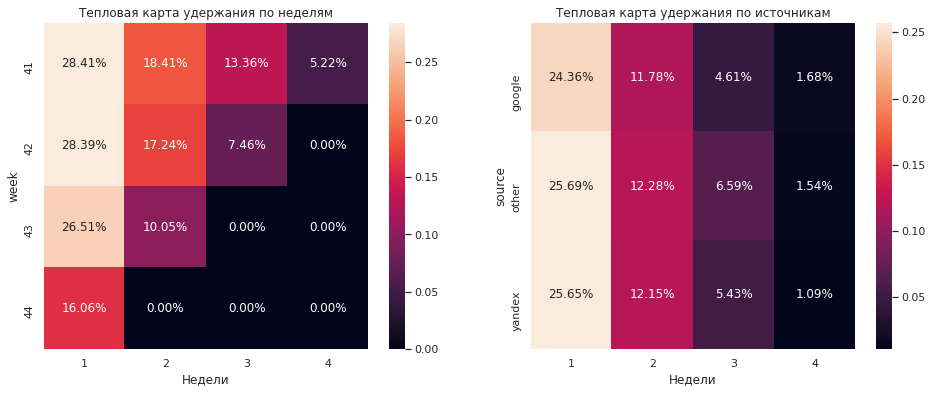

In [35]:
# строим хитмэпы
fig, axs = plt.subplots(1, 2, figsize = (16, 6))

#хитпэм удержания по неделям привлечения
sns.heatmap(
    retention.drop(columns=['cohort_size', '0']), #удаляем размеры когорт и выборку на первый день
    ax = axs[0], 
    annot=True, 
    fmt='.2%'  # переводим значения в проценты
)
axs[0].set_title('Тепловая карта удержания по неделям') 
axs[0].set_xlabel('Недели')

#хитпэм удержания по источникам установки
sns.heatmap(
    retention_source.drop(columns=['cohort_size', '0']),
    ax = axs[1], 
    annot=True, 
    fmt='.2%'      
)
axs[1].set_title('Тепловая карта удержания по источникам') 
axs[1].set_xlabel('Недели')

plt.show()

**Удержание по неделе** первого посещения.

`Доля пользователей`, совершивших первое действие в приложении на `41 неделе`:

- 28.41% зашли в приложение еще раз в течение недели;

- 18.41% заходили в приложение на следующей неделе;

- 13.36% заходили на 3 по счету неделе;

- 5.22% заходили в конце месяца (4 неделя).

`Пользователи`, привлеченные `на 42 неделе`:

- 28.39% зашли еще раз в течение недели;

- 17.24% зашли в приложение на следующей неделе;

- 7.48% зашли на 3 по счету неделе.

`Когорта пользователей`, пришедших в приложение `на 43 неделе`:

- 26.51% зашли еще раз в течение недели;

- 10.05% зашли в течение следующей недели (последней с учетом максимальной даты, которой мы располагаем).

`Пользователи 44 недели`:

- 16.06% заходили еще раз в течение недели (последней с учетом максимальной даты, которой мы располагаем).

**Удержание по источнику**, с которого пользователь установил приложение.

Пользователи, установившие приложение с разных источников, показывают близкое удержание.

- `google` - `24.36%` (в течение недели), `11.78%` (следующая неделя), `4.61%` (на 3-ей неделе), `1.68%` (последняя неделя).


- `yandex` - `25.65%` (в течение недели), `12.15%` (следующая неделя), `5.43%` (на 3-ей неделе), `1.09%` (последняя неделя).


- `other` - `25.69%` (в течение недели), `12.28%` (следующая неделя), `6.59% `(на 3-ей неделе), `1.54%` (последняя неделя).


### Вывод

В ходе подготовки профилей пользователей к кластеризации, были выполнены шаги:

- `расчет сессий и их длительности` для каждого пользователя;

- созданы `профили` пользователей;

- оценено `удержание пользователей` в зависимости от недели привлечения и источника установки.

***В структуре профилей*** сохранены такие признаки, как:

- `user_id` - id-пользователя; 

- `first_ts` - дата и время первого посещения;


- `week` - неделя, первого посещения;

- `source` - источник, с которого пользователь установил приложение;

- `spent_time` - время, проведенное в приложении (в секундах);

- `days` - количество дней, в течение которых человек пользовался приложением;

- `events` - количество совершенных событий;

- `sessions` -  количество сессий;

- `events_in_session` - среднее количество действий в сессию;

- `conversion` - конверсия в целевое действие (просмотр контактов).

***Среднее удержание*** пользователей в зависимости от недели первого посещения:

- `16 - 29%` пользователей заходят в приложение еще раз в течение недели;

- `10 - 19%` заходят еще раз в течение следующей недели;

- `7 - 14%` заходят в течение 3-ей недели со дня первого посещения;

- `до 6%` заходят в течение последней недели датасета (когорта 41 недели).

***Удержание по источникам*** установки не выявило существенных различий между группами.

- `24 - 26%` заходят еще раз в течение недели;

- `11 - 12%` заходят в течение следующей недели;

- `4 - 7%` заходят в течение 3 недели со дня первого посещения;

- `до 2%` заходят в течение последней недели датасета.

**Вывод**

У каждого пользователя мы расчитали временную разницу между соседними событиями и определили время между сессиями: 10 минут бездействия - показатель, что `пользователь`, скорее всего, `вышел из приложения`.

После чего для каждого события мы определили `номер сессии`, во время которой оно произошло. Информацию о сессиях хранит колонка 'session', а время между действиями - 'time_lag'.

**Вывод**

На данном этапе были сделаны:

- `расчет сессий` для каждого пользователя;


- подсчитана `длительность` между ближайшими `событиями`;


- созданы `профили` пользователей.

**В структуре профилей** сохранены такие признаки, как:

- `user_id` - id-пользователя; 


- `first_ts` - дата и время первого посещения;


- `week` - неделя, первого посещения;


- `source` - источник, с которого пользователь установил приложение;


- `spent_time` - время, проведенное в приложении (в секундах);


- `days` - количество дней, в течение которых человек пользовался приложением;


- `events` - количество совершенных событий;


- `sessions` -  количество сессий;


- `events_in_session` - среднее количество действий в сессию;


- `conversion` - конверсия в целевое действие (просмотр контактов).

## Кластеризация пользователей


### Корреляция признаков

Перед началом кластеризации оценим `средние показатели и корреляцию` между признаками в профилях пользователей.

In [36]:
#вспомним таблицу с профилями пользователей

profiles.head()

,user_id,first_ts,week,source,spent_time,days,events,sessions,events_in_session,conversion
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45.989359,41,other,2760.53,15,35,4,9.0,0.00
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:33.849769,42,yandex,7003.27,15,71,10,7.0,0.15
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01 13:54:35.385028,44,yandex,1482.47,1,10,1,10.0,0.00
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18 22:14:05.555052,42,google,2014.10,13,32,10,3.0,0.00
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25 16:44:41.263364,43,yandex,559.65,4,8,3,3.0,0.38


Оценим `средние значения и стандартные отклонения`.

In [37]:
profiles.describe()

,week,spent_time,days,events,sessions,events_in_session,conversion
count,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000
mean,42.412299,1325.809189,3.437223,17.283252,2.956208,7.100862,0.058374
std,1.090738,2405.407164,5.059348,29.130677,4.740561,7.276898,0.154266
min,41.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,41.000000,304.140000,1.000000,5.000000,1.000000,3.000000,0.000000
50%,42.000000,677.400000,1.000000,9.000000,2.000000,5.000000,0.000000
75%,43.000000,1436.020000,3.000000,17.000000,3.000000,8.000000,0.000000
max,44.000000,49085.590000,27.000000,478.000000,124.000000,97.000000,1.000000


Средние показатели о пользователях:

- `spent_time` - провел в приложении 1325.8 секунд (22 минуты);


- `days` - пользовался приложением в течение 3 дней;


- `events` - совершил в среднем 17 действий в приложении;


- `sessions` - состоялись 3 сессии за весь период;


- `events_in_session` - совершал в среднем 7 действий в сессию;


- `conversion` - конверсия в целевое действие 5.84%.

Мы наблюдаем в данных `большие стандартные отклонения`. 

Это говорит о том, что пользователи ведут себя по разному, и данные `не подчиняются закону нормального распределения`.

И данные необходимо будет `стандартизировать перед обучением` модели кластеризации.

**Приступим к расчету корреляции**.

В нашем наборе признаков количественные значения, и они не подчиняются закону нормального распределения. Поэтому для расчета корреляции мы воспользуемся `методом Спирмена`.

Определим степень зависимости признаков по шкале Чеддока:

<html>
 <head>
  <meta charset="utf-8">
 </head>
 <body>
  <table border="1", align="left">
   <tr>
    <th>Значение</th>
    <th>Связь</th>
   </tr>
   <tr>
    <td>0.1 - 0.3</td>
    <td>Слабая</td>
   </tr>   
   <tr>
    <td>0.3 - 0.5</td>
    <td>Умеренная</td>
    </tr>
    <tr>
    <td>0.5 - 0.7</td>
    <td>Заметная</td>
    </tr>
    <tr>
    <td>0.7 - 0.9</td>
    <td>Высокая</td>
    </tr>
    <tr>
    <td>0.9 - 0,99</td>
    <td>Весьма высокая</td>
  </tr>
 </table>
 </body>
</html>


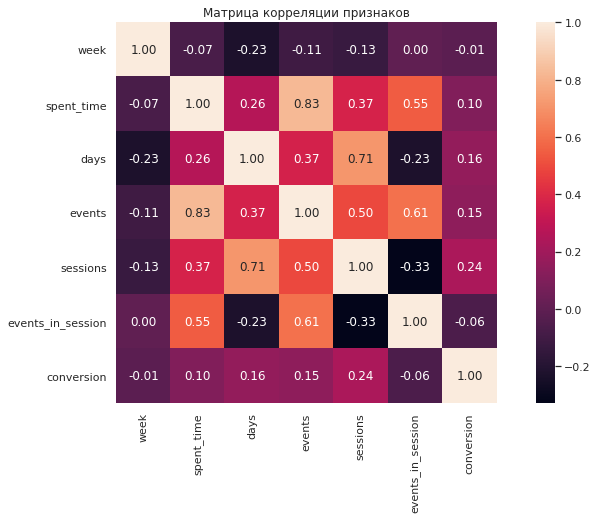

In [38]:
#построим матрицу корреляции

plt.figure(figsize = (14,7))
sns.heatmap(profiles.corr(method='spearman'), annot = True, fmt = '.2f',  square=True)

plt.title('Матрица корреляции признаков')
plt.show()

**Умеренные взаимосвязи** были обранужены между признаками:

- `'spent_time' - 'sessions'` (0.37);

Чем больше пользователь провел времени в приложении, тем, вероятнее всего, он больше совершил сессий.

- `days - events` (0.37);

Чем дольше пользователь пользовался приложением, тем больше всего он совершил событий.

- `'sessions' - 'events_in_sessions'` (-0.33).

Чем больше пользователь совершает сессий, тем меньше действий в них входит.


**Заметные взаимосвязи** наблюдаются между:

- `'spent_time' - 'events_in_session'` (0.55);

Чем больше пользователь провел времени в приложении, тем выше показатель количества действий, которые он совершил в течение сессии.

- `'events' - 'sessions'` (0.5);

Чем больше пользователь совершил действий, тем, вероятнее всего, он овершал больше сессий в приложении.

- `'events' - 'events_in_session'` (0.61).

Чем больше событий совершено пользователем, тем выше их количество в течение одной сессии.

**Высокие корреляции** наблюдаются между:

- `'days' - 'sessions'` (0.71);

Чем больше дней пользователь пользовался приложением, тем больше он совершил сессий.

- `'spent_time' - 'events'` (0.83).

Чем больше пользователь провел времени в приложении, тем болше действий он совершил.


Отметим, что признак `events_in_session` функциональный по отношению к `events` и `sessions` - наблюдается **полная коллинеарность**.

При обучении модели кластеризации мы не будем учитывать этот признак.

### Кластеры и обучение

- Определим оптимальное количество кластеров с помощью "метода локтя".


- Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.


- оценим средние показатели поведения кластеров.

In [39]:
# обучаем нормализатор и преобразуем набор данных

scaler = StandardScaler()

x_sc = scaler.fit_transform(profiles.drop(columns = ['user_id', 'first_ts', 'source', 'week', 'events_in_session'])) 

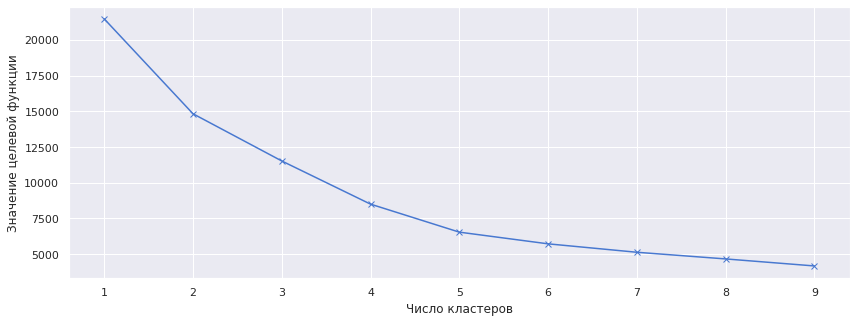

In [40]:
#применим "метод локтя" для определения оптимального кол-ва кластеров

distortion = []
K = range(1, 10)
for k in K:
    model = KMeans(n_clusters=k, random_state=123)
    model.fit(x_sc)
    distortion.append(model.inertia_)
    
#визуализируем метод
plt.figure(figsize=(14, 5))
plt.plot(K, distortion, 'bx-')
plt.xlabel('Число кластеров')
plt.ylabel('Значение целевой функции')
plt.show()

После `5 точки` наблюдается плавное снижение.

`Обучим модель кластеризации` на основании алгоритма `K-Means` и `спрогнозируем кластеры` клиентов. 

Укажем число кластеров `5`.

In [41]:
km = KMeans(n_clusters = 5, random_state = 123)
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
profiles['cluster'] = labels

In [42]:
#рассмотрим средние значения и сколько пользователей попало в группы

display(
    profiles.groupby('cluster').mean(),
    profiles['cluster'].value_counts()
)

,week,spent_time,days,events,sessions,events_in_session,conversion
cluster,,,,,,,
0,42.533193,906.058129,1.516596,11.808087,1.898310,7.415812,0.019046
1,41.729675,1441.386382,13.514228,19.648374,4.922764,4.583333,0.038333
2,42.038674,7587.990552,11.734807,94.895028,13.972376,9.988950,0.049945
3,42.474403,838.105666,2.320819,12.255973,2.597270,5.860068,0.538567
4,41.230769,27759.143077,21.307692,356.230769,52.923077,9.846154,0.136923


0    3314
1     492
3     293
2     181
4      13
Name: cluster, dtype: int64

**Вывод**

Приведем подробное описание средних показателей по кластерам.

В **0 кластер** вошло `3 314` пользователей. Для них свойствены средние показатели:

- `spent_time` (время, проведенное в приложении) - 906.06 секунд (`около 15 минут`);

- `days` (кол-во дней, в течение которых чуловек пользовался приложением) - `около 2 дней`;

- `events` (кол-во совершенных действий) - `около 12 событий`;

- `sessions` (кол-во сессий) - `около 2 сессий`;

- `events_in_session` (кол-во событий в сессии) - `7 событий в сессию`;

- `conversion` (конверсия в целевое действие) - `1.9%`.

В **1 кластер** вошло `492` пользователя. Для них свойствены средние показатели:

- `spent_time` (время, проведенное в приложении) - 1 441.39 секунд (`около 24 минут`);

- `days` (кол-во дней, в течение которых чуловек пользовался приложением) - `около 13 дней`;

- `events` (кол-во совершенных действий) -`около 20 событий`;

- `sessions` (кол-во сессий) - `около 5 сессий`;

- `events_in_session` (кол-во событий в сессии) - `5 событий в сессию`;

- `conversion` (конверсия в целевое действие) - `3.83%`.


В **2 кластер** вошло `181` пользователь. Для них свойствены средние показатели:

- `spent_time` (время, проведенное в приложении) - 7 588 секунд (`около 2 часов`);

- `days` (кол-во дней, в течение которых чуловек пользовался приложением) - `около 12 дней`;

- `events` (кол-во совершенных действий) - `около 95 событий`;

- `sessions` (кол-во сессий) - `около 14 сессий`;

- `events_in_session` (кол-во событий в сессии) - `10 событий в сессию`;

- `conversion` (конверсия в целевое действие) - `5%`.

Во **3 кластер** вошло `293` пользователя. Для них свойствены средние показатели:

- `spent_time` (время, проведенное в приложении) - 838.1 секунд (`около 14 минут`);

- `days` (кол-во дней, в течение которых чуловек пользовался приложением) - `около 2 дней`;

- `events` (кол-во совершенных действий) - `около 12 событий`;

- `sessions` (кол-во сессий) - `около 3 сессий`;

- `events_in_session` (кол-во событий в сессии) - `6 событий в сессию`;

- `conversion` (конверсия в целевое действие) - `53.85%`.

В **4 кластер** вошло всего лишь `13` пользователей. Для них свойствены средние показатели:

- `spent_time` (время, проведенное в приложении) - 27 759.14 секунд (`около 8 часов`);

- `days` (кол-во дней, в течение которых чуловек пользовался приложением) - `около 21 дня`;

- `events` (кол-во совершенных действий) - `около 356 событий`;

- `sessions` (кол-во сессий) - `около 53 сессии`;

- `events_in_session` (кол-во событий в сессии) - `10 событий в сессию`;

- `conversion` (конверсия в целевое действие) - `13.69%`.

### Анализ поведения групп.

1. ***Проанализируем данные*** в каждой группе по:

- `времени`, проведённом в приложении;


- `частоте действий`;


- `конверсии` в целевое действие - просмотр контактов.


2. Построим тепловую карту ***удержания*** с указанием признака "кластер".

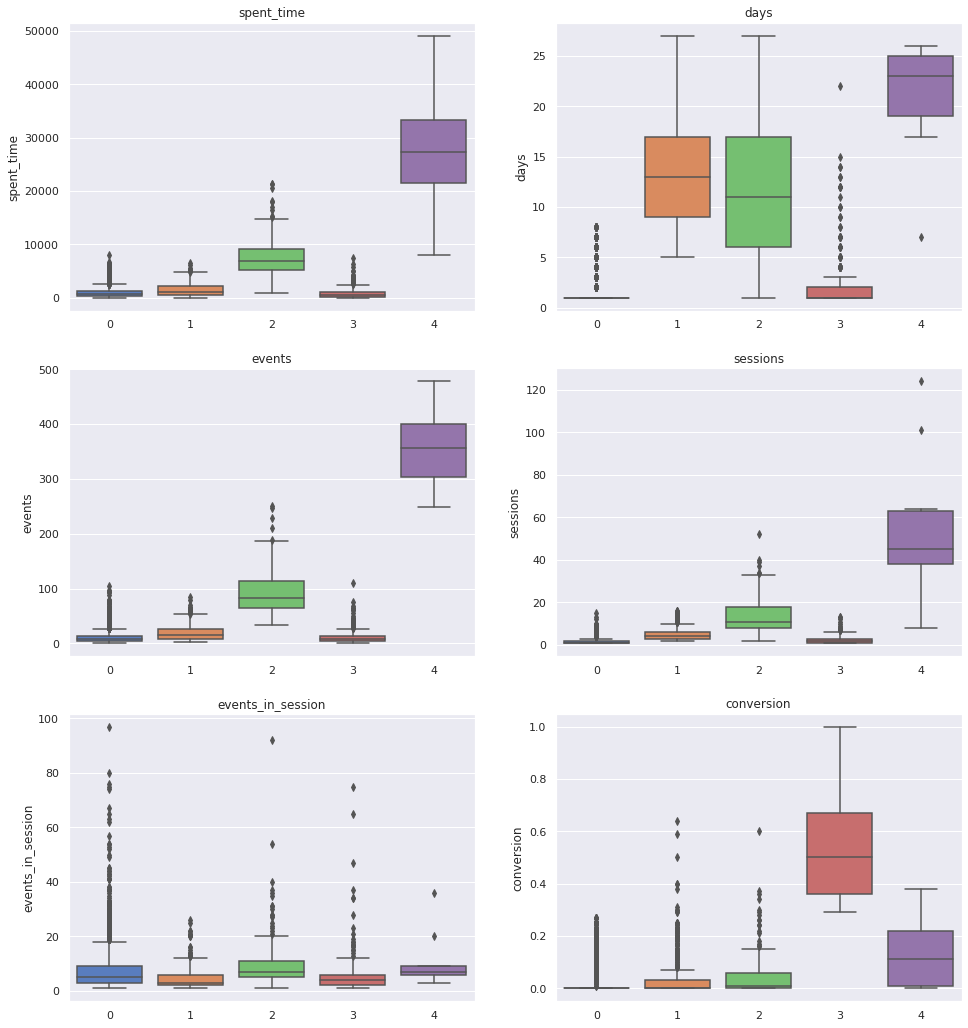

In [43]:
fig, axs = plt.subplots(3, 2, figsize = (16,18))
a = 0
b = 0

for col in profiles.drop(columns = ['user_id','first_ts', 'week', 'source', 'cluster']).columns:
    sns.boxplot(ax = axs[a, b], x ='cluster', y = col, data = profiles)
    axs[a, b].set_title(col)
    axs[a, b].set_xlabel("")
    if b == 0:
         b = 1
    else:
        a += 1
        b = 0


По распределению признаком можно выделить `4 группы по общему поведению`:

`Основным показателем` для разделения служит `конверсия` в целевое действие.

***"Золотые" пользователи***

К ним относится `3 кластер` пользователей (293 человека).

- `конверсия` в целевое действие `40 - 70%`;


- `немного времени` провели в приложении - `до 2 000 секунд` (около 33 минуты);


- совершили `до 50 действий` в приложении;


- частота действий в сессию - `около 6 событий в сессию`.

***Активные пользователи***

К ним относится `4 кластер` пользователей (13 человек).

- `конверсия` в целевое действие `до 21%`;


- `много времени` провели в приложении - `20 000 - 35 000 секунд` (5 - 10 часов);


- совершили `300 - 400 действий` в приложении;


- частота действий в сессию - `около 10 событий в сессию`.

***Среднестатистические пользователи***

К ним относятся `1 и 2 кластеры` пользователей (673 человека).

- `конверсия` в целевое действие `до 10%`;


- `среднее время`, проведенное в приложении - `2 000 - 10 000 секунд` (от 33 минут до - 3 часов);


- совершили либо `до 50 действий`, либо `50 - 120 действий` в приложении;


- частота действий в сессию - `около 5 - 10 событий в сессию`.

***Пользователи, склонные к оттоку***

К ним относится `0 кластер` пользователей (3 314 человек).

- `конверсия` в целевое действие `ближется к 0` (среднее - 1.98%);


- `немного времени` провели в приложении - `до 2 000 секунд` (около 33 минуты);


- совершили `до 50 действий`;


- частота действий в сессию - `около 7 событий в сессию`.

**Удержание пользователей по кластерам**

In [44]:
retention_raw_clusters, retention_clusters = get_retention(
    profiles, dataset, dimensions = ['cluster', 'week'])

retention_clusters.head()

cohort_size    0         1         2        3        4
cluster week                                                        
0       41            764  1.0  0.181937  0.003927  0.00000  0.00000
        42            841  1.0  0.181926  0.005945  0.00000  0.00000
        43            887  1.0  0.188275  0.012401  0.00000  0.00000
        44            822  1.0  0.136253  0.000000  0.00000  0.00000
1       41            219  1.0  0.438356  0.648402  0.47032  0.16895

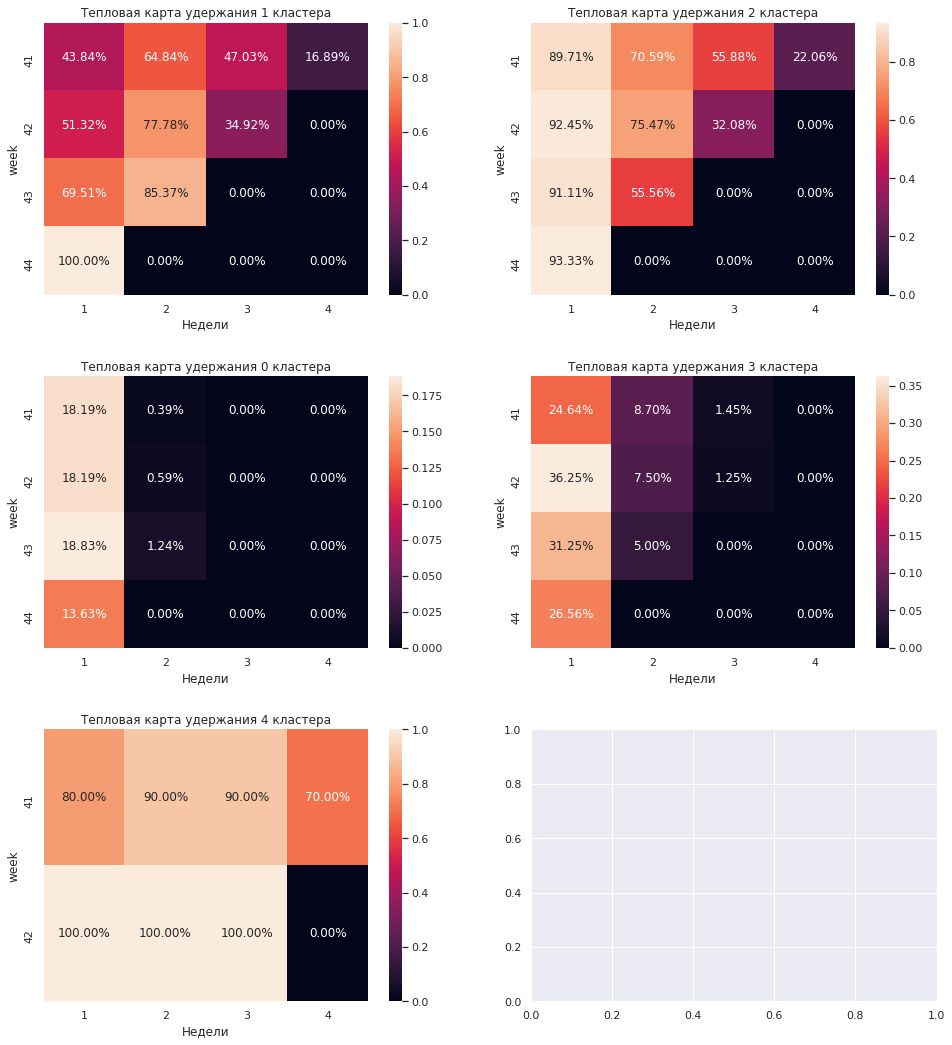

In [45]:
#построим тепловые карты удержания

fig, axs = plt.subplots(3, 2, figsize = (16,18))
plt.subplots_adjust(hspace= 0.3)

a = 0
b = 0

for cluster in profiles['cluster'].unique(): # построим график по каждому кластеру
    cluster = cluster
    sns.heatmap(
        (
    retention_clusters             # преобразуем таблицу удержания
    .reset_index()                 # удалим мультииндекс
    .query('cluster == @cluster')  # сделаем срез по кластеру
    .set_index('week')             # недели привлечения делаем индексом
    ) 
    .drop(columns=['cluster', 'cohort_size', '0']),  #исключаем колонки с кластером, размером когорты и 1 день посещения
    ax = axs[a, b], 
        annot=True, 
        fmt='.2%'      
    )
    axs[a, b].set_title('Тепловая карта удержания {} кластера'.format(cluster)) 
    axs[a, b].set_xlabel('Недели')
    
    if b == 0:
        b = 1
    else:
        a += 1
        b = 0
    

В кластеры попали пользоатели из разных недель привлечения.

Кто-то `удерживался до конца 4 недели` со дня первого посещения, кто-то `попал в отток`, а какие-то группы просто `не успели "дожить"` до 4 недели со дня своего привлечения.

Поэтому мы расчитаем `среднее удержание по кластерам`, учитывая момент, что определенные пользователи могли не "дожить" до последней недели анализа.

Если этого не сделать, то среднее недельное удержание сильно снизится из-за наличия 0% в "недоживших" группах.

Будем исключать нулевое удержание.

In [46]:
#создадим датафрейм, удалив мультииндекс, размер когорты и 0 неделю удержания (100%)

df = (
    retention_clusters
    .reset_index()
    .drop(columns = ['cohort_size', '0'])
)

df.head()

,cluster,week,1,2,3,4
0,0,41,0.181937,0.003927,0.00000,0.00000
1,0,42,0.181926,0.005945,0.00000,0.00000
2,0,43,0.188275,0.012401,0.00000,0.00000
3,0,44,0.136253,0.000000,0.00000,0.00000
4,1,41,0.438356,0.648402,0.47032,0.16895


In [47]:
retention_cluster = pd.DataFrame(index = [0, 1, 2, 3 ,4]) #создадим пустой датафрейм с кластерами в индексах

for cluster in df['cluster'].unique():
    data = df[df['cluster'] == cluster] # срез таблицы по каждому кластеру
    
    for col in df[['1', '2', '3', '4']]: 
        data_col = data[col]
        data_col = data_col.replace(0, np.nan).dropna()  #заполним в столбце и удалим nan
        mean = data_col.mean()                           #посчитаем среднее
        retention_cluster.loc[cluster, col] = mean       #сохраним среднее по неделе в созданном датафрейме

In [48]:
retention_cluster

,1,2,3,4
0,0.172098,0.007424,NaN,NaN
1,0.661676,0.759946,0.409763,0.168950
2,0.916508,0.672052,0.439789,0.220588
3,0.296750,0.070652,0.013496,NaN
4,0.900000,0.950000,0.950000,0.700000


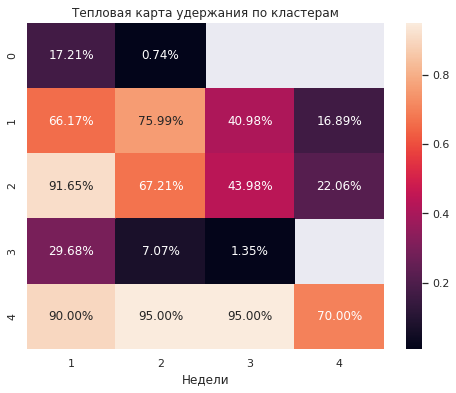

In [49]:
#визуализируем удержание по кластерам

plt.figure(figsize = (8, 6)) 

sns.heatmap(
            retention_cluster, 
            annot = True,  
            fmt = '.2%' 
           )
plt.title('Тепловая карта удержания по кластерам') 
plt.xlabel('Недели')

plt.show()

***Пользователи, склонные к оттоку*** (0 кластер) `удерживаются обычно 2 недели`:

- `17.21%` пользователей заходили в приложении еще раз в течение недели со дня первого посещения;
- `0.74%` заходили на следующей неделе.

***Среднестатистические пользователи*** удерживались на протяжении 4-х недель.

`1 кластер`:

- `66.17%` пользователей заходили в приложении еще раз в течение недели со дня первого посещения;
- `75.99%` зашли на следующей неделе;

Показатель выше предыдущего. Это говорит о том, что некоторая часть пользователей зашла в приложение еще раз только через неделю со дня первого посещения.

- `40.98%` зашли в приложении на 3 неделе;
- `16.89%` зашли в приложении на 4 неделе.

`2 кластер`:

- `91.65%` пользователей заходили в приложении еще раз в течение недели со дня первого посещения;
- `67.21%` зашли на следующей неделе;
- `43.98%` зашли в приложении на 3 неделе;
- `22.06%` зашли в приложении на 4 неделе.

***Золотые пользователи*** , привлеченные на 41 неделе в данном кластере, не заходили на 4 неделе, а пользователи из других недель привлечения "не дожили" до 4 недели анализа. Нельзя сказать, что они попали в отток: пользователи могли зайти через неделю или две, но этими данными аналитик не располагает.

`3 кластер`:

- `29.68%` пользователей заходили в приложении еще раз в течение недели со дня первого посещения;
- `7.07%` зашли на следующей неделе;
- `1.35%` зашли в приложении на 3 неделе.

***Активные пользователи*** (4 кластер) показывают самые высокие проценты удержания.

- `90%` пользователей заходили в приложении еще раз в течение недели со дня первого посещения;
- `95%` зашли на следующей неделе;

Показатель выше предыдущего. Это говорит о том, что некоторая часть пользователей зашла в приложение еще раз только через неделю со дня первого посещения.

- `95%` зашли в приложении на 3 неделе;
- `70%` зашли в приложении на 4 неделе.


### Вывод

В результате кластеризации были определены `5 кластеров` пользователей, различающихся по своему поведению в приложении: 

- по удержанию (retention rate); 

- времени, проведённом в приложении;

- количеству совершенных событий;

- частоте действий;

- конверсии в целевое действие — просмотр контактов.


***Среднестатистические пользователи.*** К ним относятся `1 и 2 кластеры` пользователей (492 и 181 пользователей соответственно).

- удержание пользователей на первой неделе со дня привлечения составляет `66.17 - 91.65%`. На последней 4 неделе в датасете удерживается `16.89 - 22.06%` пользователей.


- `среднее время`, проведенное в приложении - `2 000 - 10 000 секунд` (от 33 минут до - 3 часов);


- совершили либо `до 50 действий`, либо `50 - 120 действий` в приложении;


- частота действий в сессию - `около 5 - 10 событий в сессию`;


- `конверсия` в целевое действие `до 10%`.


***Золотые пользователи.*** К ним относится `3 кластер` пользователей (293 человека).

- долго не удерживаются (нашли, что искали, и забывают о приложении);

Среднее удержание пользователей на первой неделе со дня привлечения (зашли хотя бы раз на текущей неделе) составляет `29.68%`. На последней 3 неделе удержание значительно снижается `1.35%`. За 4 неделю в датасете нет данных об этих пользователях.

- `немного времени` провели в приложении - `до 2 000 секунд` (около 33 минуты);


- совершили `до 50 действий` в приложении;


- частота действий в сессию - `около 6 событий в сессию`;


- `конверсия` в целевое действие `40 - 70%`.

***Активные пользователи.*** К ним относится `4 кластер` пользователей (13 человек).

- самые высокие проценты удержания.

Среднее удержание пользователей на первой неделе со дня привлечения (зашли хотя бы раз на текущей неделе) составляет `90%`. 

На последней 4 неделе в датасете удержание значительно снижается `70%`.

- `много времени` провели в приложении - `20 000 - 35 000 секунд` (5 - 10 часов);


- совершили `300 - 400 действий` в приложении;


- частота действий в сессию - `около 10 событий в сессию`;


- `конверсия` в целевое действие `до 21%`.


***Пользователи, склонные к оттоку.*** К ним относится `0 кластер` пользователей (3 314 человек).

- `удерживаются обычно 2 недели`;

`17.21%` пользователей заходили в приложении еще раз в течение недели со дня первого посещения. 

`0.74%` заходили на следующей неделе.

- `немного времени` провели в приложении - `до 2 000 секунд` (около 33 минуты);


- совершили `до 50 действий`;


- частота действий в сессию - `около 7 событий в сессию`;


- `конверсия` в целевое действие `ближется к 0` (среднее - 1.98%).


## Проверка статистических гипотез

**1 гипотеза** 

Некоторые пользователи установили приложение по ссылке из `yandex`, другие — из `google`. 

`Нулевая гипотеза`: две эти группы демонстрируют `одинаковую конверсию` в просмотры контактов.

`Альтернативная гипотеза`: группы демонстрируют`разную конверсию `в просмотры контактов.

Используем `T-критерий Стьюдента` для оценки выборок.

In [50]:
#определим уровень статистической значимости

alpha = 0.05 

In [51]:
result_source = st.ttest_ind(profiles[profiles['source'] == 'google']['conversion'],
                            profiles[profiles['source'] == 'yandex']['conversion'])

In [52]:
if result_source.pvalue < alpha:
    print(result_source.pvalue, '\nОтвергаем нулевую гипотезу')
else:
    print(result_source.pvalue,'\nНе удалось отвергнуть нулевую гипотезу')

0.84418359340046 
Не удалось отвергнуть нулевую гипотезу


Мы `не можем утвердать`, что пользователи, установившие приложение из "google" и "yandex" демонстрируют`разную конверсию `в просмотры контактов.

Вероятнее всего, не этот признак влияет на поведение пользователей в приложении.

**2 гипотеза**

Кластеры пользователей, у которых средняя частота событий за сессию выше, чаще просматривают контакты (целевое событие).

`Нулевая гипотеза`: кластеры с высокой средней частотой событий за сессию и минимальной демонстрируют `одинаковую конверсию` в просмотры контактов.

`Альтернативная гипотеза`: кластеры с высокой частотой событий за сессию и минимальной демонстрируют`разную конверсию `в просмотры контактов.


In [53]:
#рассмотрим среднюю частоту действий в сессию по кластерам

profiles.groupby('cluster')['events_in_session'].mean()

cluster
0    7.415812
1    4.583333
2    9.988950
3    5.860068
4    9.846154
Name: events_in_session, dtype: float64

`2 и 4` класстеры отличаются по своим средним показателям (почти 10 дейстий за сессию).

Условно объединим их `в одну группу` с высокой частотой действий.

`Во второй` группе будут `0, 1 и 3` кластеры со средней частотой до 7 действий.

Воспользуемся снова `T-критерием Стьюдента`.

In [54]:
result_events = st.ttest_ind(profiles[(profiles['cluster'] == 2) | (profiles['cluster'] == 4)]['conversion'],
                            profiles[(profiles['cluster'] != 2) | (profiles['cluster'] != 4)]['conversion'])

In [55]:
if result_events.pvalue < alpha:
    print(result_events.pvalue, '\nОтвергаем нулевую гипотезу')
else:
    print(result_events.pvalue, '\nНе удалось отвергнуть нулевую гипотезу')

0.8158362280563208 
Не удалось отвергнуть нулевую гипотезу


Мы `не можем утверждать`, что кластеры с высокой частотой событий за сессию и минимальной демонстрируют `разную конверсию `в целевое действие (просмотры контактов).

**Вывод**

Нами были проанализированы 2 гипотезы влияние признаков на конверию в целевое действие.

***В 1 гипотезе*** были рассмотрены источники, с которых пользователь установил приложение: "google" и "yandex".

Нам `не удалось отвергнуть нулевую гипотезу`. 

Мы `не можем утвердать`, что пользователи, установившие приложение из "google" и "yandex" демонстрируют `разную конверсию `в просмотры контактов.

Вероятнее всего, не этот признак влияет на поведение пользователей в приложении.

***Во 2 гипотезе*** мы разделили кластеры пользователей на 2 условных группы: кластеры с высокой средней частотой событий за сессию и минимальной.

В ходе анализа мы `не смогли отвергнуть нулевую гипотезу` о том, что условные группы показывают одинаковую конверсию.

Мы `не можем утверждать`, что кластеры с высокой частотой событий за сессию и минимальной демонстрируют `разную конверсию `в целевое действие (просмотры контактов).

## Рекомендации

**Краткий вывод**

`Самое лучшее удержание` показывают пользователи из `4` (13 человек) и `2` (181 пользователь) кластеров.

Их количество достаточно мало по сравнению с общим объемом пользователей. Это говорит о том, что значительная часть пользователей показывает либо среднее удержание (66.17% заходили еще раз в течение недели), либо низкое и склонное к оттоку.

- `1 кластер` (492 пользователя) показывает `среднее удержание`:

`66.17%` пользователей заходили в приложении еще раз в течение недели со дня первого посещения;

`16.89%` зашли в приложении на 4 неделе (к концу месяца).


- `3 кластер` (293 человека);

Группа пользователей обладает самой высокой конверсией в целевое действие - `40 - 70%`.

`29.68%` пользователей зашли на первой неделе со дня привлечения. 

`1.35%` зашли в приложении на 4 неделе (к концу месяца).


- `0 кластер` (3 314 человек) - 77% всех пользователей, которые удерживаются только 2 недели.

`17.21%` пользователей заходили в приложении еще раз в течение недели со дня первого посещения.

`0.74%` заходили на следующей неделе.


Последние 3 группы составляют 95% от общего количества пользователей. Необходимо обратить внимание их удержание.

**Возможные причины потери интереса**

Выделим три основные причины:

- неудачный интерфейс;
- плохое первое впечатление;
- несоответствие ожиданиям.

`3 кластер` показывает высокую конверсию, но в течение недели в приложение вновь заходит только 29.68% пользователей. 

Если после первого дня использования представитель этого кластера больше не использует продукт, следовательно, причина либо в неудачном интерфейсе, либо в обманутых ожиданиях.

Также обратим внимание, что пользователи чаще находят то, что искали, и впоследствии перестают заходить в приложение в течение длительного времени.

`0 кластер` изначально склонен к оттоку: он демнстрирует низкое удержание и практически нулевую конверсию в целевое действие.

Причины оттока также могут быть связаны с плохим первым впечатлением о приложении, либо в обманутых ожиданиях (пользователи не нашли то, что искали).

**Рекомендации по удержанию пользователей**

1. Использовать персонализированные ***Push-уведомления***.

Например, `3 кластеру` стоит напоминать о себе и стимулировать его снова совершить целевое действие. 

Это могут быть напоминания о:

- отложенных товарах;

- появлении новых товаров из частых категории;

- новых предложениях у человека, с которым пользователь уже совершал сделки;

- появлении товара поблизости.


2. ***Вовлекать пользователей*** в улучшение приложения.

У `0 кластера` скорее всего изначально сформировалось плохое впечатление о приложении.

Push-уведомление или email с просьбой оценить приложение и написать отзыв могут сподвигнуть некоторых пользователей дать обратную связь, чтобы отделам маркетинга и разработки было понятно, над чем необходимо поработать.

3. ***Ввести элемент игры***

Основная ценность приложения состоит в том, что дать старым вещам новую жизнь.

Элемент игры в приложении может стимулировать желание людей совершать сделать (как отдавать, так и забирать).

Например, это могут быть `уровневые статусы` (условно, от новичка до завсегдатая по количеству совершенных сделок). Так профиль пользователя может стать интереснее и казаться более надежным для других пользователей. 

Если для определенных статусов будут `проводиться розыгрыши или конкурсы призов` от партнеров, то совершать сделки и повышать свой статус становится еще интереснее.